In [2]:
import os
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import Aer
from qiskit.algorithms.optimizers import COBYLA
from typing import List
import numpy as np
import pandas as pd
from qiskit.opflow import OperatorStateFn
from qiskit.opflow import CircuitStateFn, DictStateFn
from qiskit.opflow.expectations import CVaRExpectation
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
os.environ["QISKIT_SETTINGS"] = "qiskitrc"

In [3]:
from codes_notebook_1 import ChargingUnit, Car, generate_qcio, Converter, CplexOptimizer

In [4]:
charging_unit = ChargingUnit(
        charging_unit_id="charging_unit",
        number_charging_levels=4,
        number_time_slots=3)
car_green = Car(
        car_id="car_green",
        time_slots_at_charging_unit=[0, 1],
        required_energy=4)
charging_unit.register_car_for_charging(car_green)

car_orange = Car(
        car_id="car_orange",
        time_slots_at_charging_unit=[1, 2],
        required_energy=5)
charging_unit.register_car_for_charging(car_orange)


qcio = generate_qcio(charging_unit, name="QCIO")
converter = Converter(penalty=5.6)
qubo = converter.convert(qcio)
number_binary_variables = qubo.get_num_binary_vars()

cplex_optimizer = CplexOptimizer()
qubo_minimization_result = cplex_optimizer.solve(qubo)

In [5]:
number_binary_variables
f_3_min = qubo_minimization_result.fval
print("minimum value: f_3(b_min) = ", f_3_min)
#check if the minimum value is feasible
b_min = qubo_minimization_result.x
# reverse the order of the binary array
b_min = b_min[::-1]
# convert b_min to reverse integer array
integer_array = converter.interpret(b_min)
print("integer_array = ", integer_array)
# check if the integer array is feasible
print("is_feasible = ", qcio.is_feasible(integer_array))
# check if the integer array is optimal
print("is_optimal = ", np.isclose(qubo_minimization_result.fval, f_3_min))

minimum value: f_3(b_min) =  26.999999999999943
integer_array =  [3. 1. 0. 0. 2. 3.]
is_feasible =  True
is_optimal =  True


In [6]:
def process_qaoa_result(qaoa_result, converter, qcio, f_3_min, only_feasible=True, sortby="probability", a=False):
    #convert ant array of binary to decimal
    def binary_to_decimal(binary):
        decimal = 0
        for digit in binary:
            decimal = decimal*2 + int(digit)
        return decimal

    def binary_to_string(binary):
        STR = ""
        for digit in binary:
            #convert digit to int
            d = int(digit)
            STR += str(d)
        return STR
    
    
    df = pd.DataFrame(qaoa_result.samples, columns=['x', 'fval', 'probability'])
    
    df['bit_array'] = df['x'].apply(lambda bitstring: np.fromiter(bitstring, dtype=int)[::-1])
    df['decimal_index'] = df['bit_array'].apply(lambda x: binary_to_decimal(x))
    df['bit_string'] = df['bit_array'].apply(lambda x: binary_to_string(x))
    df.sort_values(by=sortby, ascending=a, inplace=True)
    df["integer_array"] = df["bit_array"].apply(converter.interpret)
    df = df[['decimal_index',"bit_array", "bit_string", "integer_array", "probability", "fval"]]
    df["is_feasible"] = df["integer_array"].apply(qcio.is_feasible)
    df["is_optimal"] = df["fval"].apply(lambda x: np.isclose(x, f_3_min))
    if only_feasible:
        df = df[df["is_feasible"] == True]
        df['probability'] = df['probability'] / df['probability'].sum()
    return df

In [7]:
# Run this cell only once if you want changing random numbers in the cell below
seed = 199
random_generator = np.random.default_rng(seed)

In [8]:
from tqdm import tqdm

In [10]:
#use qasm simulator to get samples
experiments = 800

max_reps = [6]

for reps in max_reps:
    cost = []
    prob = []
    optimal = []
    ising, ising_offset = qubo.to_ising()
    qaoa_reps = reps
    qaoa_ansatz = QAOAAnsatz(cost_operator=ising, reps=qaoa_reps, name='qaoa')
    qaoa_ansatz.measure_active()
    number_of_shots = 8192*2
    observable = OperatorStateFn(ising, is_measurement=True)
    cobyla_optimizer = COBYLA()
    #try:
    #    parameter_values_initial_guess = np.load(f"qaoa_parameters_{qaoa_reps}.npy")
    #except:
    #    betas_initial_guess = np.pi*random_generator.random(qaoa_reps)
    #   gammas_initial_guess = 2*np.pi*random_generator.random(qaoa_reps)
    #    parameter_values_initial_guess = [*betas_initial_guess, *gammas_initial_guess]
    
    
    for i in tqdm(range(experiments)):
        quantum_instance = Aer.get_backend('aer_simulator_statevector_gpu')
        qaoa = QAOA(quantum_instance=quantum_instance, reps=qaoa_reps)
        qaoa_optimizer = MinimumEigenOptimizer(qaoa)
        qaoa_result = qaoa_optimizer.solve(qubo)
        df = process_qaoa_result(qaoa_result, converter, qcio, f_3_min, only_feasible=True, sortby="probability", a=False)
        #merge the results 
        
        if i == 0:
            try:
                df_all = pd.read_csv(f'qaoa_{qaoa_reps}.csv')
            except: 
                df_all = df
        else:
            df_all = pd.concat([df_all, df])
            
            df_all = df_all.groupby('decimal_index').agg({'bit_array': 'first', 'bit_string': 'first', 'integer_array': 'first', 'probability': 'sum', 'fval': 'first', 'is_feasible': 'first', 'is_optimal': 'first'})
            df_all['probability'] = df_all['probability'] / df_all['probability'].sum()
            df_all.sort_values(by="probability", ascending=False, inplace=True)
        
        #print("Experiment ", i+1, 'reps',reps+1)
        cost.append(df_all['fval'].iloc[0])
        prob.append(df_all['probability'].iloc[0])
        optimal.append(df_all[df_all['is_optimal']==True]['probability'].iloc[0])
        
        
        #parameter_values_initial_guess = qaoa_result.min_eigen_solver_result.optimal_point
    #np.save(f"qaoa_parameters_{qaoa_reps}.npy", qaoa_result.min_eigen_solver_result.optimal_point)
    
    print('reps',reps,' Completed')
    print("Cost = ", df_all['fval'].iloc[0])
    print("Probability = ", df_all['probability'].iloc[0])
    print("Optimal Schedule Probability = ", df_all[df_all['is_optimal']==True]['probability'].iloc[0])
    print('------------------------------------')
    
    data = {'cost': cost, 'probability': prob, 'optimal': optimal}
    daf = pd.DataFrame(data)
    daf.to_csv(f'qaoa_results_{qaoa_reps}.csv', index=False,  mode='a', header=False)
    df_all.to_csv(f'qaoa_{qaoa_reps}.csv', index=False)
#save the optimized parameters


    #p_sum = df_all[df_all["is_optimal"] == True]['probability'].sum()
    #print("probability sum = ", p_sum)
    #normalize the probability
    
        
    

  0%|          | 0/800 [00:00<?, ?it/s]

In [299]:
#optimal parameters


array([-2.57582721,  1.11210198, -0.33307178, 14.03119626,  6.21018594,
       10.64709198])

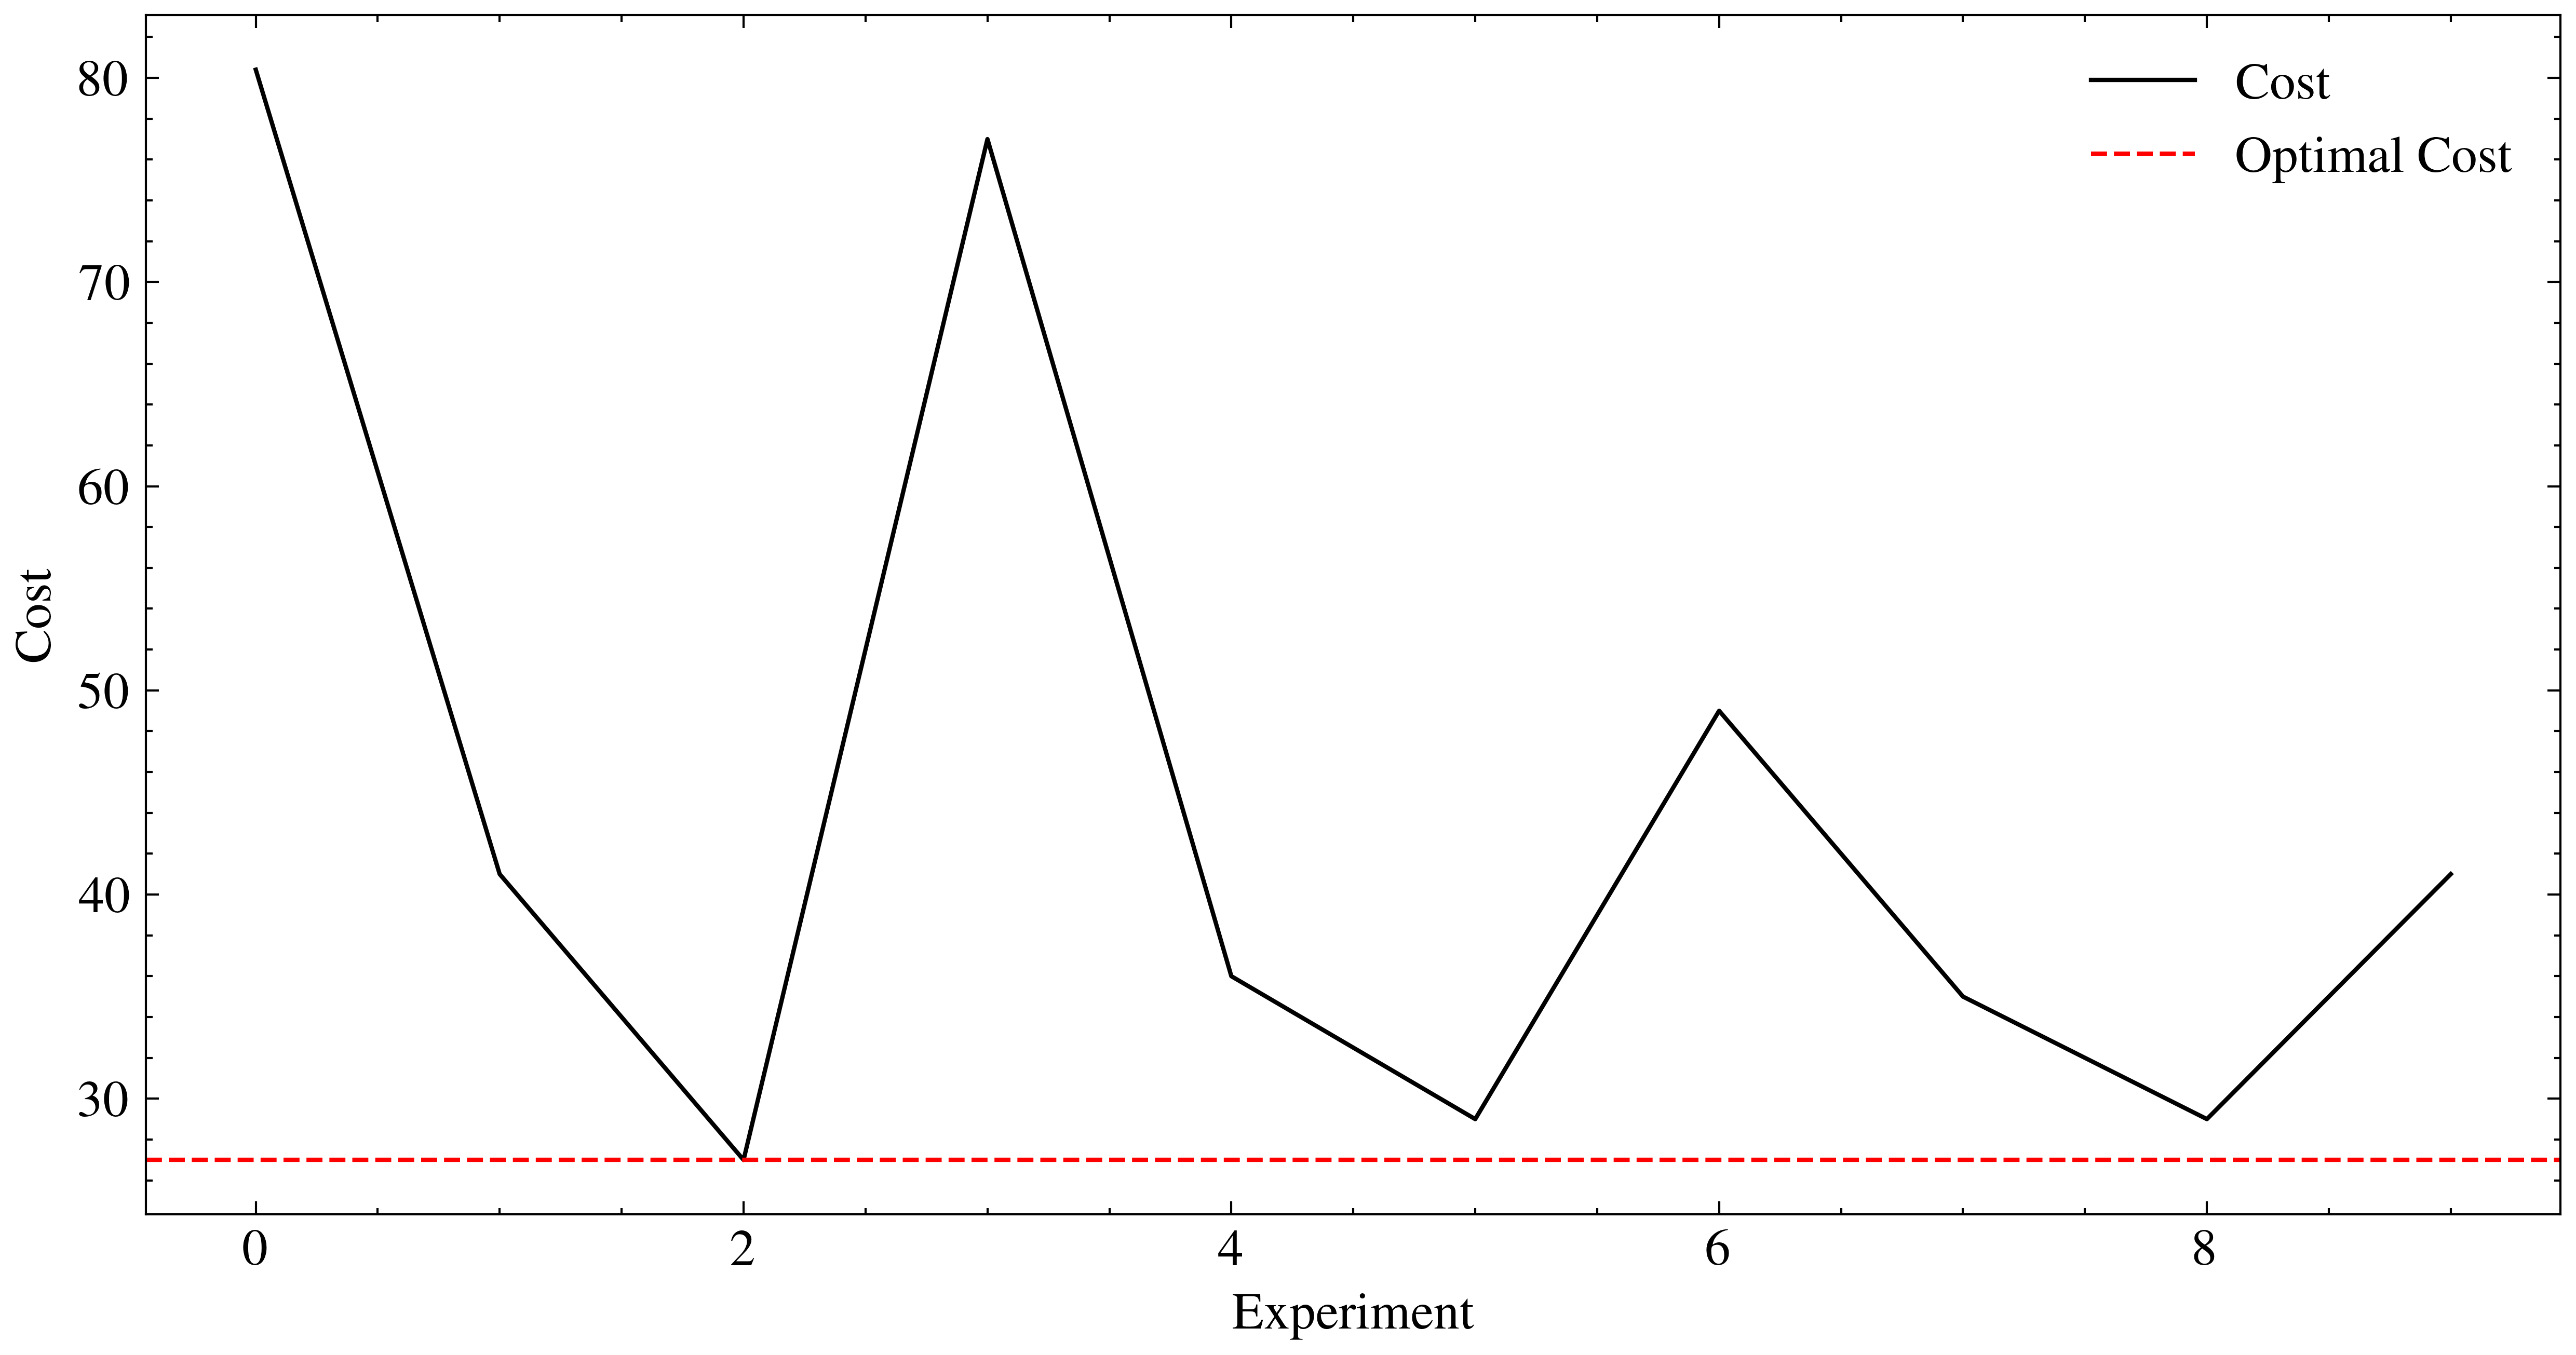

In [289]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.figure(figsize=(10, 5))
plt.plot(cost, label="Cost")
plt.xlabel("Experiment")
plt.ylabel("Cost")
#draw the horizontal line for the optimal cost
plt.axhline(y=f_3_min, color='r', linestyle='--', label="Optimal Cost")
plt.legend()
plt.show()



In [271]:
df_all[df_all["is_optimal"] == True]

,bit_array,bit_string,integer_array,probability,fval,is_feasible,is_optimal
decimal_index,,,,,,,
3591,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]",111000000111,"[3.0, 1.0, 0.0, 0.0, 2.0, 3.0]",0.016804,27.0,True,True


In [ ]:

    )
    print("probability = ", df_all.iloc[0]["probability"])
    print("fval = ", df_all.iloc[0]["fval"])
    print("#################")

In [253]:
#print the top f_val and probability
print("f_3_min = ", f_3_min)
print("probability = ", df_all.iloc[0]["probability"])
print("fval = ", df_all.iloc[0]["fval"])

f_3_min =  26.999999999999943
probability =  0.2050968493343404
fval =  27.00000000000003


In [216]:
df_all['probability'].sum()

3.0000000000000004

In [229]:
df_test = df_all.copy()
top_10  = df_test.groupby("index").agg({"probability": "sum"}).sort_values(by="probability", ascending=False).head(10)

KeyError: 'index'

In [236]:
df_all['fval']

163     43.0
2736    99.4
162     43.0
411     50.0
1926    79.4
        ... 
35      34.0
1215    66.0
1809    77.0
2714    98.4
903     61.0
Name: fval, Length: 283, dtype: float64

In [221]:
top_10['probability']/3

bit_string
111010000111    0.054252
010100111101    0.051547
010100001101    0.048987
101100001101    0.041487
010110000111    0.041185
111000000111    0.038847
101100000111    0.033123
111000001101    0.031428
101100100111    0.026226
010100000111    0.024018
Name: probability, dtype: float64

In [213]:
#check if the bitstrings are same then remove the duplicates and sum the probabilities
df_all = df_all.groupby([ 'fval']).sum().reset_index()

<ipython-input-213-22b40cea5a3c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all = df_all.groupby([ 'fval']).sum().reset_index()


In [204]:
#sum onlt the probabilities
p = df['probability']
#normalize the probabilities
p = p/np.sum(p)
np.sum(p)

1.0

In [198]:
#store in a dataframe indexed by the binary variables , fval, probability
df = process_qaoa_result(qaoa_result, converter, qcio, f_3_min, only_feasible=True, sortby="probability", a=False)
df

,bit_array,bit_string,integer_array,probability,fval,is_feasible,is_optimal
189,"[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]",101101001101,"[1.0, 3.0, 2.0, 0.0, 3.0, 2.0]",0.008949,44.0,True,False
659,"[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]",101101101101,"[1.0, 3.0, 2.0, 1.0, 3.0, 2.0]",0.003873,56.0,True,False
360,"[1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]",101110001101,"[1.0, 3.0, 1.0, 0.0, 3.0, 2.0]",0.001650,49.0,True,False
10,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]",101100000111,"[1.0, 3.0, 0.0, 0.0, 2.0, 3.0]",0.001531,29.0,True,False
660,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]",101111000111,"[1.0, 3.0, 3.0, 0.0, 2.0, 3.0]",0.001505,56.0,True,False
...,...,...,...,...,...,...,...
1787,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]",101111111101,"[1.0, 3.0, 3.0, 3.0, 3.0, 2.0]",0.000005,77.0,True,False
1415,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]",111010111101,"[3.0, 1.0, 1.0, 3.0, 3.0, 2.0]",0.000004,70.0,True,False
413,"[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]",111010010111,"[3.0, 1.0, 1.0, 2.0, 2.0, 3.0]",0.000004,50.0,True,False
898,"[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]",101111011101,"[1.0, 3.0, 3.0, 2.0, 3.0, 2.0]",0.000002,61.0,True,False


In [193]:
#show the optimal solution
df[df["is_optimal"]]

,bit_array,bit_string,integer_array,probability,fval,is_feasible,is_optimal
0,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]",111000000111,"[3.0, 1.0, 0.0, 0.0, 2.0, 3.0]",0.000764,27.0,True,True


In [111]:
df

,x,bit_string,integer_array,probability,fval,is_feasible,is_optimal
12,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",110011011110,"[2.0, 0.0, 2.0, 1.0, 2.0, 1.0]",0.000977,22.0,True,False
13,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",011011011101,"[1.0, 1.0, 2.0, 1.0, 2.0, 1.0]",0.000977,22.0,True,False
14,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",110110010111,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0]",0.000977,22.0,True,False
155,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",110011110111,"[2.0, 0.0, 2.0, 2.0, 1.0, 2.0]",0.000977,33.0,True,False
72,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",110110110111,"[2.0, 1.0, 1.0, 2.0, 1.0, 2.0]",0.000977,29.0,True,False


In [47]:
def energy_evaluation(parameter_values: List[float]):
    "parameter_values is expected to be of the form [beta_0, beta_1, ..., gamma_0, gamma_1, ...]"
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))

    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

    result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
    counts = result.get_counts()
    sqrt_probabilities = {bitstring: np.sqrt(count/number_of_shots) for bitstring, count in counts.items()}
    
    expectation = np.real(observable.eval(sqrt_probabilities)) + ising_offset
    
    return expectation

In [56]:
result_optimization = cobyla_optimizer.minimize(fun=energy_evaluation, x0=parameter_values_initial_guess)

parameter_values_optimized = result_optimization.x
energy_optimized = result_optimization.fun
number_function_evaluations = result_optimization.nfev # Number of evalutions of energy_evaluation

print("Standard:")
print("  optimized parameters:", parameter_values_optimized)
print("  expectation value:", energy_optimized)
print("  number function evaluations:", number_function_evaluations)

Standard:
  optimized parameters: [2.65845822 2.9382968  0.21049682 1.49228619 3.36565789 6.18698922
 1.47265731 0.37144551]
  expectation value: 24.437377929687514
  number function evaluations: 93


In [36]:




qaoa_ansatz_wo_measurement = qaoa_ansatz.copy()
qaoa_ansatz_wo_measurement.remove_final_measurements()

expectation_operator = observable @ CircuitStateFn(qaoa_ansatz_wo_measurement)

cvar_expectation_converter = CVaRExpectation(alpha=cvar_alpha)
expectation_operator_cvar = cvar_expectation_converter.convert(expectation_operator)
measurement_cvar = expectation_operator_cvar[0]

def energy_evaluation_cvar(parameter_values: List[float]):
    "parameter_values is expected to be of the form [beta_0, beta_1, ..., gamma_0, gamma_1, ...]"
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))

    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

    result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
    counts = result.get_counts()
    sqrt_probabilities = {bitstring: np.sqrt(count/number_of_shots) for bitstring, count in counts.items()}
    sqrt_probabilities_dict_state = DictStateFn(sqrt_probabilities)
    
    expectation = np.real(measurement_cvar.eval(sqrt_probabilities_dict_state)) + ising_offset
    
    return expectation

In [49]:
result_optimization_cvar = cobyla_optimizer.minimize(fun=energy_evaluation_cvar, x0=parameter_values_initial_guess)

parameter_values_optimized_cvar = result_optimization_cvar.x
energy_optimized_cvar = result_optimization_cvar.fun
number_function_evaluations_cvar = result_optimization_cvar.nfev # Number of evalutions of energy_evaluation_cvar

print(f"CVaR, alpha={cvar_alpha}:")
print("  optimized parameters:", parameter_values_optimized_cvar)
print("  cvar expectation value:", energy_optimized_cvar)
print("  number function evaluations:", number_function_evaluations_cvar)

CVaR, alpha=0.08:
  optimized parameters: [1.38848235 2.7927964  4.34885178 5.8962427 ]
  cvar expectation value: 6.000000000000011
  number function evaluations: 33
